# FYS-STK 4155 H20 PROJECT 1

## Definitions

In [1]:
NOISE = .05
NUM_SAMPLES = 1000
MAX_POLY_ORDER = 15
NUM_BOOTSTRAPS = 20
np.random.seed(0)

In [2]:
# From the assignment; The function that we are goint to approximate
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [3]:
# Generate samples from the FrankeFunction with some optional noise
def franke_sampler(x, y, noise=.1):
    f = FrankeFunction(x, y).reshape(len(x), 1)
    var_eps = noise * np.var(f)
    z = f + np.sqrt(var_eps)*np.random.randn(len(x), 1)
    return (z, f, var_eps)

In [4]:
# Create a mesh with sn uniform randomly scattered points in the rectangle (x_start, y_start), (x_end, y_end). Returned ndarrays have shape (sn, 1)
def randmesh(sn=500, x_start=0., y_start=0., x_end=1., y_end=1., random_state=0):
    np.random.seed(random_state)
    x = np.random.uniform(x_start, x_end, (sn, 1))
    y = np.random.uniform(y_start, y_end, (sn, 1))
    return (x, y)

In [5]:
# Make design matrix with polinomial degree np in two variables
def make_design_matrix(x, y, pn=5):
    X = np.ndarray([len(x), int((pn+1)*(pn+2)/2)])

    ex = [0]*int((pn+1)*(pn+2)/2)
    ey = [0]*int((pn+1)*(pn+2)/2)
    kx = ky = 0
    for i in range(pn+1):
        for j in range(i+1):
            ex[kx] = j
            kx += 1
        for j in range(i,-1,-1):
            ey[ky] = j
            ky += 1

    for i, (xi, yi) in enumerate(zip(x, y)):
        X[i,:] = [(xi**px)*(yi**py) for px, py in zip(ex, ey)]
    
    return X

In [6]:
# Defining some useful functions
def mse(y, y_tilde):
    return np.mean(np.mean((y - y_tilde)**2, axis=1, keepdims=True))

def r2(y, y_tilde):
    return 1 - sum((y - np.mean(y_tilde, axis=1, keepdims=True))**2)/sum((y - np.mean(y))**2)

def bias(f, y_tilde):
    return np.mean((f - np.mean(y_tilde, axis=1, keepdims=True))**2)

def var(y):
    return np.mean(np.var(y, axis=1, keepdims=True))

def best_r2(mse_array, y):
    return 1 - np.min(mse_array)/np.mean(sum((z - np.mean(z))**2)/len(z))

def truncate_to_poly(X, pn):
    p = int((pn+1)*(pn+2)/2)
    return np.copy(X[:,:p])

def center(X):
    X = np.copy(X)
    if X.shape[1] == 1:
        return X
    X -= np.mean(X, axis=0, keepdims=True)
    X[:,0] = 1
    return X

def center_scale(X):
    X = np.copy(X)
    if X.shape[1] == 1:
        return X
    means = np.mean(X, axis=0, keepdims=True)
    stds = np.std(X, axis=0, keepdims=True)
    stds[0,0] = 1
    X = (X - means) / stds
    X[:,0] = 1
    return X    

# NOTE: Choose k such that len(z)%k is zero, ie the split is even!
def split(y, k):
    n = len(y)
    s = n//k  # samples in each split
    last_idx = n - n%k  # remove overshooting samples
    test_splits = [list(range(i, i+s)) for i in range(0, last_idx, s)]
    train_splits = [list(set(range(last_idx)) - set(test_split)) for test_split in test_splits]
    return (train_splits, test_splits)

## OLS with bootstrap resampling

In [94]:
def ols_bootstrap(*arrays, train_size=.7, bootstraps=30):
    train_test_arrays = skl.model_selection.train_test_split(*arrays, train_size=train_size)
    if len(train_test_arrays) < 4:
        X_train, X_test, z_train, z_test = train_test_arrays[:4]
        f_test = z_test
    else:
        X_train, X_test, z_train, z_test, _, f_test = train_test_arrays
    
    X_train = center(X_train)
    X_test = center(X_test)
    
    mse_train = np.ndarray(bootstraps)
    z_test_tilde = np.ndarray((len(z_test), bootstraps))
    
    for bs in range(bootstraps):
        X_resampled, z_resampled = skl.utils.resample(X_train, z_train, random_state=bs)
        beta_hat = np.linalg.pinv(X_resampled) @ z_resampled
        mse_train = mse(z_resampled, X_resampled @ beta_hat)
        z_test_tilde[:, bs] = (X_test @ beta_hat).ravel()
    
    mse_train = np.mean(mse_train)
    mse_test = mse(z_test, z_test_tilde)
    bias_test = bias(z_test, z_test_tilde)
    var_test = var(z_test_tilde)
    
    return (mse_train, mse_test, bias_test, var_test)

### OLS bias-variance tradeoff

In [211]:
x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=NOISE)

ols_bs_df = DataFrame(columns=["pol order", "train mse", "mse", "bias", "var"])

for pn in range(MAX_POLY_ORDER):
    Xpn = truncate_to_poly(X, pn)
    results = ols_bootstrap(Xpn, z, f, train_size=.7, bootstraps=NUM_BOOTSTRAPS)
    ols_bs_df.loc[pn] = [pn, *results]

print(best_r2(ols_bs_df["mse"], z))

0.9418669932012874


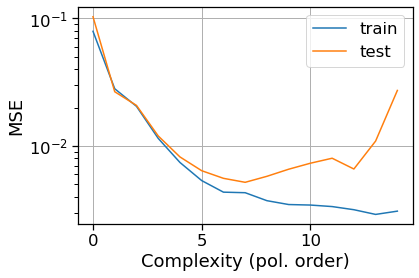

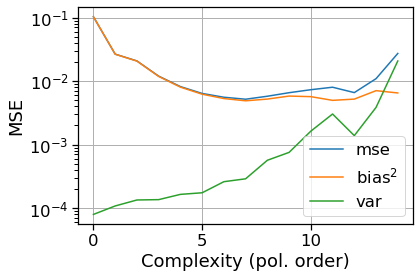

In [212]:
ax = ols_bs_df.plot(x="pol order", y=["train mse", "mse"], logy=True)
ax.legend(["train", "test"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")

ax.grid(True)
plt.show()

ax = ols_bs_df.plot(x="pol order", y=["mse", "bias", "var"], logy=True)
ax.legend(["mse", "bias$^2$", "var"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")
#ax.set_xlim(0,15)
#ax.set_ylim(1E-4,1)
ax.grid(True)
plt.show()

## OLS with $k$-fold cross-validation resampling
The data is randomized, so we don't need to do that again.

In [41]:
def ols_kfold(X, z, k=50):
    splits = split(z, k)

    mse_train = np.ndarray(k)
    mse_test = np.ndarray(k)

    for i, (train_split, test_split) in enumerate(zip(*splits)):
        X_train = X[train_split]
        z_train = z[train_split]
        X_test = X[test_split]
        z_test = z[test_split]

        X_train = center(X_train)
        X_test = center(X_test)        

        beta_hat = np.linalg.pinv(X_train) @ z_train
        mse_train[i] = mse(z_train, X_train @ beta_hat)
        mse_test[i] = mse(z_test, X_test @ beta_hat)

    return (np.mean(mse_train), np.mean(mse_test))

### OLS train vs. test MSE

In [213]:
x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=NOISE)

ols_k_df = DataFrame(columns=["pol order", "train", "test"])

for pn in range(MAX_POLY_ORDER):
    Xpn = truncate_to_poly(X, pn)
    results = ols_kfold(Xpn, z, k=25)
    ols_k_df.loc[pn] = [pn, *results]

print(best_r2(ols_k_df["test"], z))

0.9180617507321158

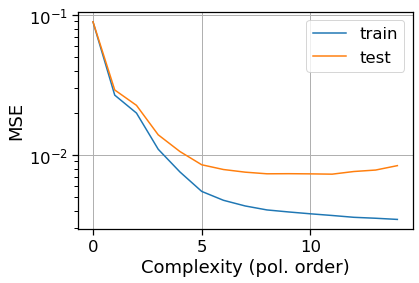

In [214]:
ax = ols_k_df.plot(x="pol order", logy=True)
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")

ax.grid(True)
plt.show()

## Ridge with bootstrap resampling

In [265]:
def ridge_bootstrap(*arrays, lambdas=[], train_size=.5, bootstraps=30):
    train_test_arrays = skl.model_selection.train_test_split(*arrays, train_size=train_size)
    if len(train_test_arrays) < 4:
        X_train, X_test, z_train, z_test = train_test_arrays[:4]
        f_test = z_test
    else:
        X_train, X_test, z_train, z_test, _, f_test = train_test_arrays
   
    n, p = X_train.shape
    X_train = X_train[:p,:p]
    z_train = z_train[:p]
    X_test = X_test[:p,:p]
    z_test = z_test[:p]
    f_test = f_test[:p]

    scaler = skl.preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_train[:,0] = 1
    X_test[:,0] = 1
    
    num_lambdas = len(lambdas)
    mse_train_buf = np.ndarray(bootstraps)
    mse_train = np.ndarray(num_lambdas)
    mse_test = np.ndarray(num_lambdas)
    bias_test = np.ndarray(num_lambdas)
    var_test = np.ndarray(num_lambdas)
    
    z_test_tilde = np.ndarray((p, bootstraps))
    
    for i, lmd in enumerate(lambdas):
        L = lmd*np.identity(p)
        
        for bs in range(bootstraps):
            X_resampled, z_resampled = skl.utils.resample(X_train, z_train, random_state=bs)  
            beta_hat = np.linalg.inv(X_resampled.T @ X_resampled + L) @ X_resampled.T @ z_resampled
            mse_train_buf[bs] = mse(z_resampled, X_resampled @ beta_hat)       
            z_test_tilde[:,bs] = (X_test @ beta_hat).ravel()

        mse_train[i] = np.mean(mse_train_buf)
        mse_test[i] = mse(z_test, z_test_tilde)
        bias_test[i] = bias(f_test, z_test_tilde)
        var_test[i] = var(z_test_tilde)
    
    return (mse_train, mse_test, bias_test, var_test)

### Ridge bias-variance tradeoff

In [276]:
x, y = randmesh(sn=10000)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=NOISE)

lambdas = np.logspace(-4, 2, 500)
polynomial_orders = list(range(10, 22+1, 3))

test_cols = [f"mse_{pn} bias_{pn} var_{pn}" for pn in polynomial_orders]
test_cols = " ".join(test_cols)
test_cols = test_cols.split()

ridge_bs_df = DataFrame(columns=["lambda", "train"] + test_cols)
ridge_bs_df["lambda"] = lambdas

for pn in polynomial_orders:
    Xpn = truncate_to_poly(X, pn)
    mse_train, mse_test, bias_test, var_test = ridge_bootstrap(Xpn, z, f, lambdas=lambdas, train_size=.5, bootstraps=NUM_BOOTSTRAPS)
    ridge_bs_df[f"train"] = mse_train
    ridge_bs_df[f"mse_{pn}"] = mse_test
    ridge_bs_df[f"bias_{pn}"] = bias_test
    ridge_bs_df[f"var_{pn}"] = var_test

0.7753059445066601


In [278]:
pn = 13
print(best_r2(ridge_bs_df[f"mse_{pn}"], z))

0.8376977081929301


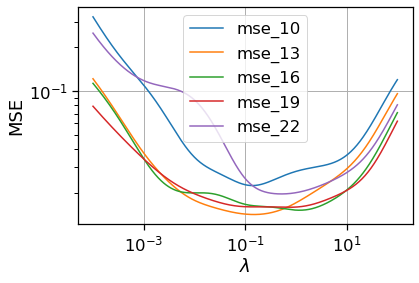

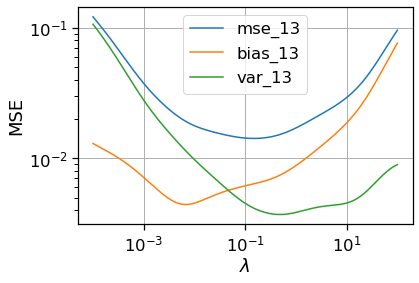

In [279]:
ax = ridge_bs_df.plot(x="lambda", y=[f"mse_{pn}" for pn in polynomial_orders], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

ax = ridge_bs_df.plot(x="lambda", y=[f"mse_{pn}", f"bias_{pn}", f"var_{pn}"], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

plt.show()

## Ridge with $k$-fold cross-validation resampling

In [260]:
def ridge_kfold(X, z, lambdas=[], k=50):
    splits = split(z, k)
    
    num_lambdas = len(lambdas)
    mse_train = np.ndarray(num_lambdas)
    mse_test = np.ndarray(num_lambdas)
    
    mse_train_buf = np.ndarray(k)
    mse_test_buf = np.ndarray(k)
    
    for i, lmd in enumerate(lambdas):
        for j, (train_split, test_split) in enumerate(zip(*splits)):
            X_train = X[train_split]
            z_train = z[train_split]
            X_test = X[test_split]
            z_test = z[test_split]

            n, p = X_train.shape
            X_train = X_train[:p,:p]
            z_train = z_train[:p]
            X_test = X_test[:p,:p]
            z_test = z_test[:p]      
            
            scaler = skl.preprocessing.StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            X_train[:,0] = 1
            X_test[:,0] = 1
            
            beta_hat = np.linalg.inv(X_train.T @ X_train + lmd*np.identity(p)) @ X_train.T @ z_train
            
            mse_train_buf[j] = mse(z_train, X_train @ beta_hat)
            mse_test_buf[j] = mse(z_test, X_test @ beta_hat)

        mse_train[i] = np.mean(mse_train_buf)
        mse_test[i] = np.mean(mse_test_buf)
    
    return (mse_train, mse_test)

### Ridge train vs. test MSE

In [270]:
#%%timeit -n1 -r1
x, y = randmesh(sn=10000)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=NOISE)

lambdas = np.logspace(-7, 2, 50)
polynomial_orders = list(range(3, MAX_POLY_ORDER+1, 3))

test_cols = [f"train_{pn} test_{pn}" for pn in polynomial_orders]
test_cols = " ".join(test_cols)
test_cols = test_cols.split()

ridge_k_df = DataFrame(columns=["lambda"] + test_cols)
ridge_k_df["lambda"] = lambdas

for pn in polynomial_orders:
    Xpn = truncate_to_poly(X, pn)
    mse_train, mse_test = ridge_kfold(Xpn, z, lambdas=lambdas, k=25)
    ridge_k_df[f"train_{pn}"] = mse_train
    ridge_k_df[f"test_{pn}"] = mse_test

print(best_r2(ridge_k_df[f"test_{pn}"], z))

0.9166726221327344


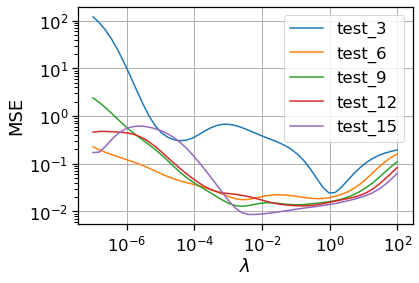

In [264]:
ax = ridge_k_df.plot(x="lambda", y=[f"test_{pn}" for pn in polynomial_orders], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

In [30]:
#plt.figure(figsize=(10,5))
#sns.heatmap(DataFrame(Vt.T @ np.linalg.inv(S**2 + L) @ S @ U.T))

In [31]:
#plt.figure(figsize=(10,5))
#sns.heatmap(DataFrame(Vt.T @ np.linalg.pinv(X_resampled)))

## LASSO with bootstrap resampling

In [62]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def lasso_bootstrap(*arrays, lambdas=[], train_size=.7, bootstraps=30, **kwargs):
    train_test_arrays = skl.model_selection.train_test_split(*arrays, train_size=train_size)
    if len(train_test_arrays) < 4:
        X_train, X_test, z_train, z_test = train_test_arrays[:4]
        f_test = z_test
    else:
        X_train, X_test, z_train, z_test, _, f_test = train_test_arrays
    
    scaler = skl.preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    X_train[:,0] = 1
    X_test[:,0] = 1
    
    num_lambdas = len(lambdas)
    mse_train_buf = np.ndarray(bootstraps)
    mse_train = np.ndarray(num_lambdas)
    mse_test = np.ndarray(num_lambdas)
    bias_test = np.ndarray(num_lambdas)
    var_test = np.ndarray(num_lambdas)
    
    beta_hat = np.ndarray((X_train.shape[1], 1))
    z_test_tilde = np.ndarray((z_test.shape[0], bootstraps))
    
    for i, lmd in enumerate(lambdas):
        lasso = skl.linear_model.Lasso(alpha=lmd, fit_intercept=False, **kwargs)
        
        for bs in range(bootstraps):
            X_resampled, z_resampled = skl.utils.resample(X_train, z_train, random_state=bs)  
            
            lasso.fit(X_resampled, z_resampled)
            beta_hat[:,0] = lasso.coef_
            
            mse_train_buf[bs] = mse(z_resampled, X_resampled @ beta_hat)
            z_test_tilde[:,bs] = (X_test @ beta_hat).ravel()

        mse_train[i] = np.mean(mse_train_buf)
        mse_test[i] = mse(z_test, z_test_tilde)
        bias_test[i] = bias(f_test, z_test_tilde)
        var_test[i] = var(z_test_tilde)
    
    return (mse_train, mse_test, bias_test, var_test)

In [91]:
#%%timeit -n1 -r1
x, y = randmesh(sn=1000)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=NOISE)

lambdas = np.logspace(-9, 2, 30)
polynomial_orders = list(range(3,MAX_POLY_ORDER+1, 3))
#polynomial_orders = [6]

test_cols = [f"mse_{pn} bias_{pn} var_{pn}" for pn in polynomial_orders]
test_cols = " ".join(test_cols)
test_cols = test_cols.split()

lasso_bs_df = DataFrame(columns=["lambda", "train"] + test_cols)
lasso_bs_df["lambda"] = lambdas

for pn in polynomial_orders:
    Xpn = truncate_to_poly(X, pn)
    mse_train, mse_test, bias_test, var_test = lasso_bootstrap(Xpn, z, f, lambdas=lambdas, train_size=.7, bootstraps=5, max_iter=1E5, warm_start=True, precompute=True)
    lasso_bs_df[f"train"] = mse_train
    lasso_bs_df[f"mse_{pn}"] = mse_test
    lasso_bs_df[f"bias_{pn}"] = bias_test
    lasso_bs_df[f"var_{pn}"] = var_test


In [94]:
pn = 9
print(best_r2(lasso_bs_df[f"mse_{pn}"], z))

0.934530955478318


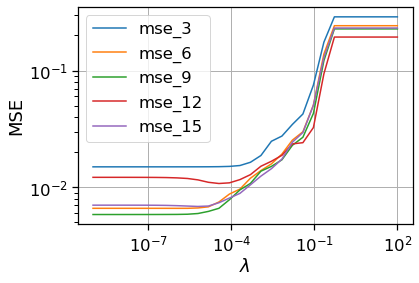

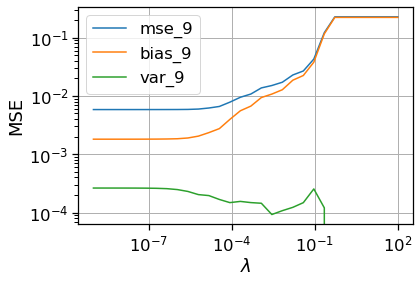

In [96]:

ax = lasso_bs_df.plot(x="lambda", y=[f"mse_{pn}" for pn in polynomial_orders], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

pn = pn
ax = lasso_bs_df.plot(x="lambda", y=[f"mse_{pn}", f"bias_{pn}", f"var_{pn}"], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

plt.show()